<a href="https://colab.research.google.com/github/Iamsdt/UdacityPyTorch/blob/master/src/notebook/MLP_With_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [48]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

#data set
train_data = datasets.MNIST(root="data",train=True,download=True,transform=transform)
test_data = datasets.MNIST(root="data",train=False,download=True,transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_set)
print(num_train)

60000


In [0]:
# Index of num train
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [0]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

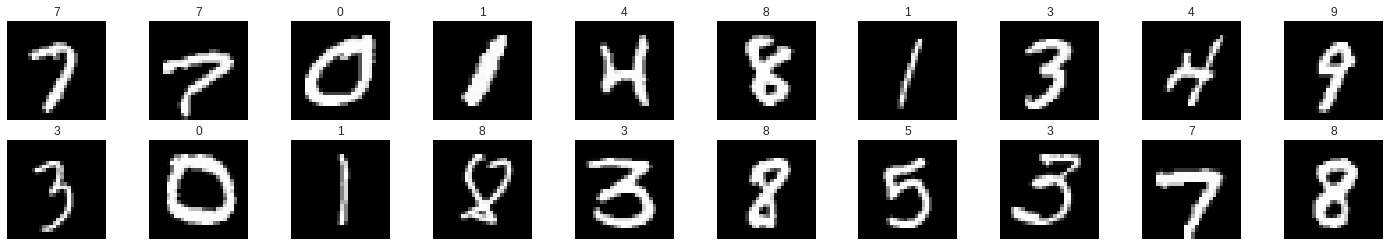

In [19]:
# Visualize data

import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

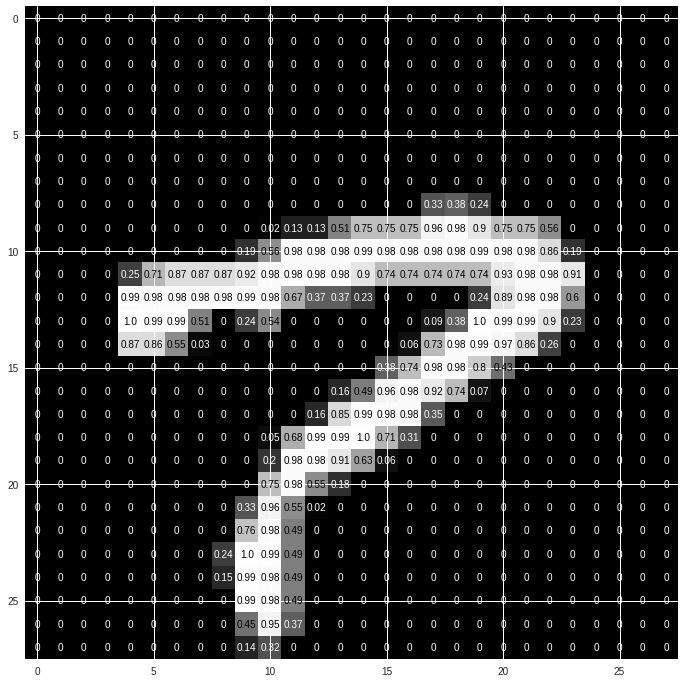

In [20]:
# View Image with more details
img = np.squeeze(images[1])
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
  
  def __init__(self):
    super(Network, self).__init__()
    # number of hidden nodes in each layer (512)
    hidden_1 = 512
    hidden_2 = 512
    # linear layer (784 -> hidden_1)
    self.fc1 = nn.Linear(28 * 28, hidden_1)
    # linear layer (n_hidden -> hidden_2)
    self.fc2 = nn.Linear(hidden_1, hidden_2)
    # linear layer (n_hidden -> 10)
    self.fc3 = nn.Linear(hidden_2, 10)
    # dropout layer (p=0.2)
    # dropout prevents overfitting of data
    self.dropout = nn.Dropout(0.2)
    
    
  def forward(self,x):
    x = x.view(-1,784) # 28*28
    # add hidden layer, with relu activation function
    x = F.relu(self.fc1(x))
    # add dropout layer
    x = self.dropout(x)
    # add hidden layer, with relu activation function
    x = F.relu(self.fc2(x))
    # add dropout layer
    x = self.dropout(x)
    # add output layer
    x = self.fc3(x)
    return x

In [33]:
model = Network()
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [34]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#move tensor to default device
model.to(device)

Network(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [35]:
# number of epochs to train the model
n_epochs = 50

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.424785 	Validation Loss: 0.179563
Validation loss decreased (inf --> 0.179563).  Saving model ...
Epoch: 2 	Training Loss: 0.522441 	Validation Loss: 0.094096
Validation loss decreased (0.179563 --> 0.094096).  Saving model ...
Epoch: 3 	Training Loss: 0.365128 	Validation Loss: 0.076097
Validation loss decreased (0.094096 --> 0.076097).  Saving model ...
Epoch: 4 	Training Loss: 0.313196 	Validation Loss: 0.068218
Validation loss decreased (0.076097 --> 0.068218).  Saving model ...
Epoch: 5 	Training Loss: 0.282924 	Validation Loss: 0.062732
Validation loss decreased (0.068218 --> 0.062732).  Saving model ...
Epoch: 6 	Training Loss: 0.260938 	Validation Loss: 0.058698
Validation loss decreased (0.062732 --> 0.058698).  Saving model ...
Epoch: 7 	Training Loss: 0.241902 	Validation Loss: 0.055270
Validation loss decreased (0.058698 --> 0.055270).  Saving model ...
Epoch: 8 	Training Loss: 0.226289 	Validation Loss: 0.052189
Validation loss decreased (0.05527

In [0]:
# load the saved model
model.load_state_dict(torch.load('model.pt'))

In [39]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # Move input and label tensors to the default device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(16):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.077474

Test Accuracy of     0: 97% (235/241)
Test Accuracy of     1: 98% (284/288)
Test Accuracy of     2: 96% (255/263)
Test Accuracy of     3: 98% (258/261)
Test Accuracy of     4: 95% (259/270)
Test Accuracy of     5: 97% (211/216)
Test Accuracy of     6: 96% (216/223)
Test Accuracy of     7: 97% (257/263)
Test Accuracy of     8: 96% (216/223)
Test Accuracy of     9: 96% (256/264)

Test Accuracy (Overall): 97% (2447/2512)


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fc33d38b9e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil

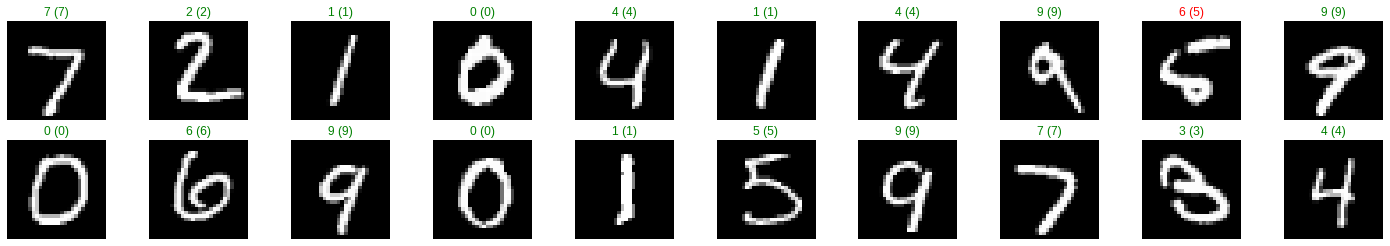

In [50]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# Move to cpu
model.cpu()
  
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))